In [39]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

from hmmlearn.hmm import GaussianHMM

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from scripts.utils import complete_auto_corr

In [40]:
df = pd.read_csv('../data/time_series_15min_singleindex.csv')
df = df[['cet_cest_timestamp', 'DE_50hertz_wind_generation_actual']]
df.columns = ['Timestamp', 'Value']
df.index = pd.to_datetime(df['Timestamp'], utc=True)
df = df.drop('Timestamp', axis=1)
df = df[df.index.year >= 2007]
df = df.fillna(df.rolling(24*4, min_periods=1).median())
df

,Value
Timestamp,
2007-01-01 00:00:00+00:00,5148.000
2007-01-01 00:15:00+00:00,5284.000
2007-01-01 00:30:00+00:00,5423.000
2007-01-01 00:45:00+00:00,5608.000
2007-01-01 01:00:00+00:00,5661.000
...,...
2019-04-30 22:45:00+00:00,2556.719
2019-04-30 23:00:00+00:00,2500.904
2019-04-30 23:15:00+00:00,2503.766


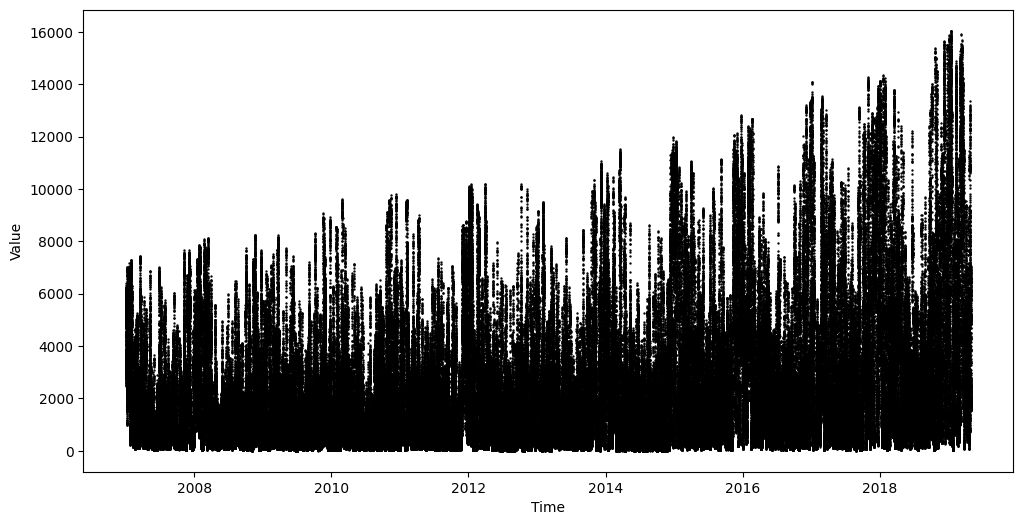

In [41]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

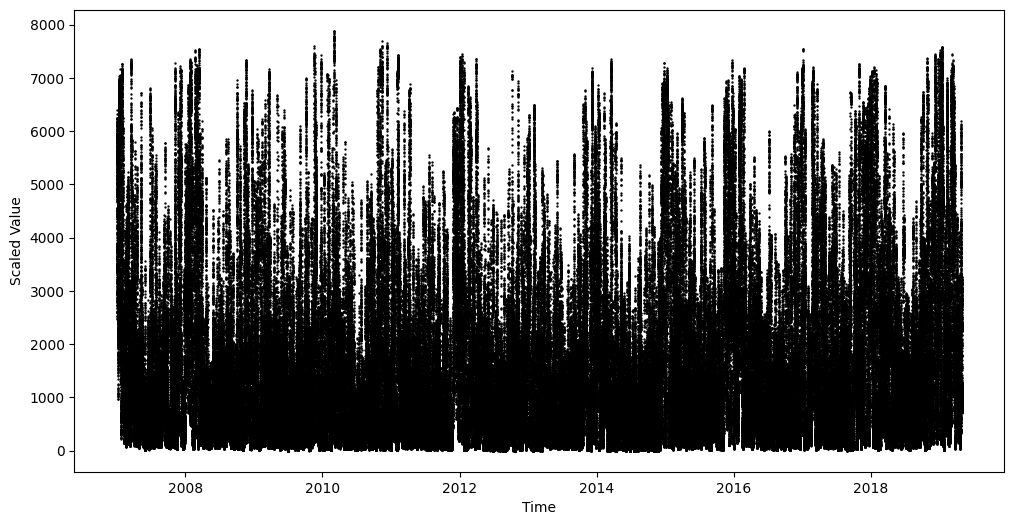

In [42]:
df['Log Value'] = np.log(df['Value'] + 1)

tmp_values = df['Log Value'].rolling(window=24*4*30).quantile(.99).dropna().to_numpy()
t = np.arange(len(tmp_values))
m, c = np.polyfit(t, tmp_values, 1)

df['Log Value'] = df['Log Value'] - m*np.arange(len(df['Log Value']))

df['Scaled Value'] = np.exp(df['Log Value']) - 1
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Scaled Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.show()

In [43]:
window = 24*4*3
df['Moving Std'] = df['Scaled Value'].rolling(window=window).std()
df['Moving Momentum'] = df['Scaled Value'].rolling(window=window).apply(lambda x: np.mean(np.diff(x)))
df.dropna(inplace=True)

In [44]:
generation = df[['Moving Std', 'Moving Momentum']].values
generation = (generation - generation.mean(axis=0)) / generation.std(axis=0)

# model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
# model.fit(generation)
# with open('../models/hmm.pkl', 'wb') as f:
#     pickle.dump(model, f)

with open('../models/hmm.pkl', 'rb') as f:
    model = pickle.load(f)
    
df["Regime"] = model.predict(generation)
df['Regime'] = df['Regime'].shift(-window // 2)
df['Regime'] = df['Regime'].ffill()

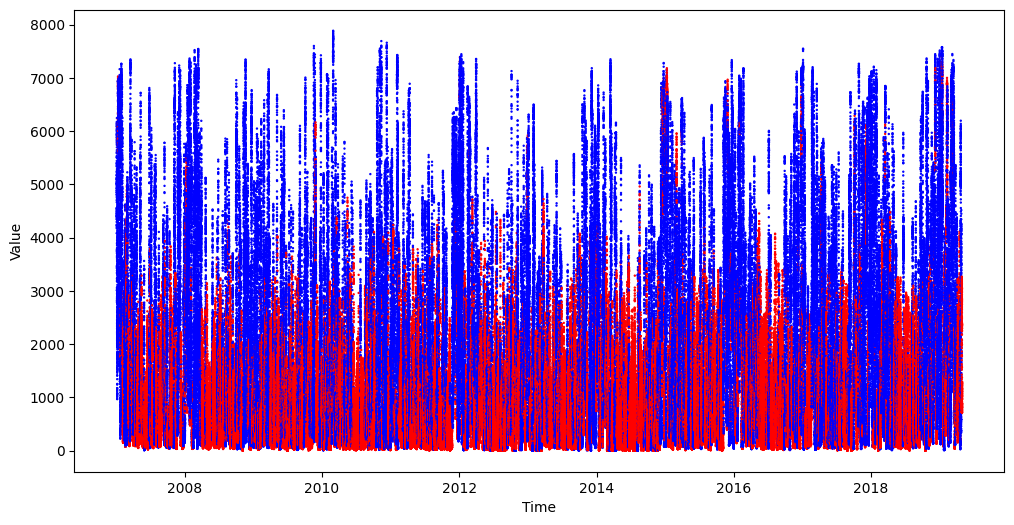

In [45]:
color_mapping = {0: 'b', 1: 'r'}

df['Color'] = df['Regime'].map(color_mapping)
df.to_csv('../data/real_data.csv')

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Scaled Value'], c=df['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

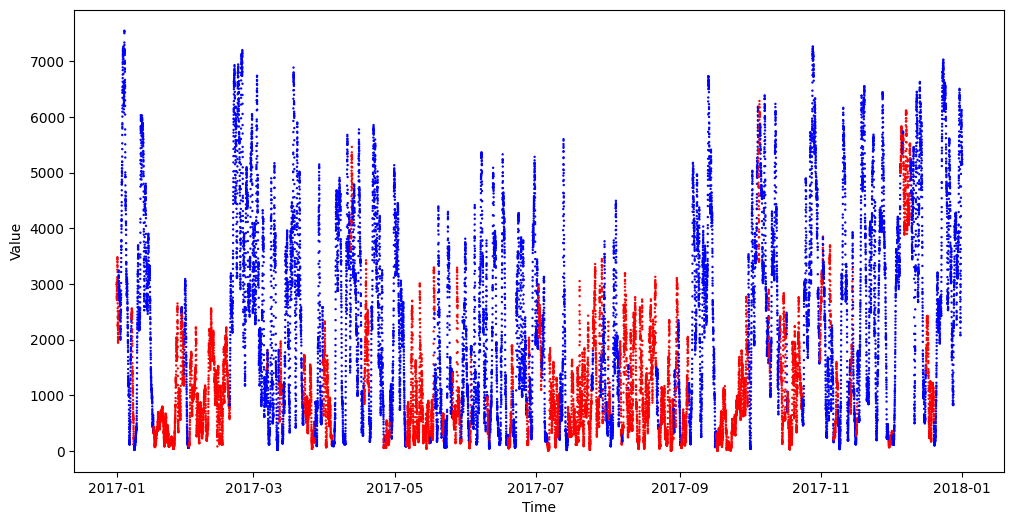

In [46]:
plt.figure(figsize=(12, 6))
plt.scatter(df.loc['2017'].index, df.loc['2017']['Scaled Value'], c=df.loc['2017']['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [47]:
df['Day'] = df.index.date
regime_df = pd.DataFrame(df.groupby('Day')['Regime'].value_counts(normalize=True).unstack())
regime_df.fillna(0, inplace=True)
regime_df.index = pd.to_datetime(regime_df.index)
regime_df

Regime,0.0,1.0
Day,,
2007-01-03,1.000000,0.000000
2007-01-04,1.000000,0.000000
2007-01-05,1.000000,0.000000
2007-01-06,1.000000,0.000000
2007-01-07,1.000000,0.000000
...,...,...
2019-04-26,1.000000,0.000000
2019-04-27,1.000000,0.000000
2019-04-28,0.385417,0.614583


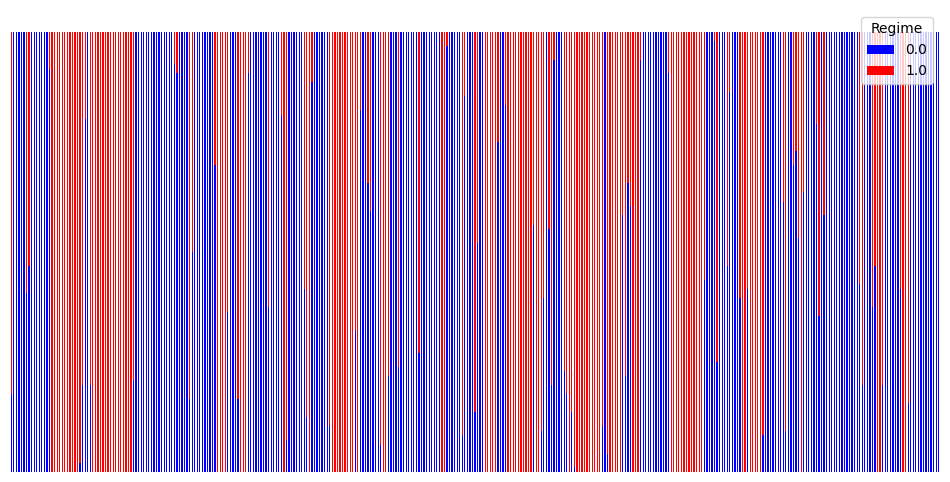

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
regime_df.loc['2017'].plot(kind='bar', stacked=True, ax=ax, color=['b', 'r'])
ax.axis('off');

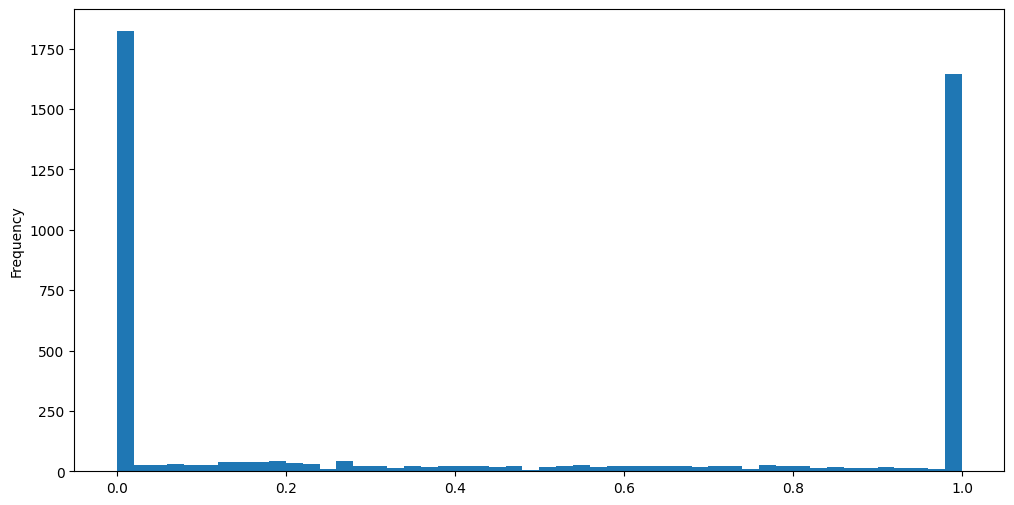

In [49]:
regime_df[0].plot(kind='hist', figsize=(12, 6), bins=50);

In [50]:
regime_df['Regime'] = (regime_df[0] > regime_df[1]).astype(int)
regime_df['Regime'].value_counts()

Regime
0    2440
1    2061
Name: count, dtype: int64

In [51]:
df['Diff'] = df['Scaled Value'].diff()
time_series_df = regime_df[['Regime']].join(df.groupby('Day')['Diff'].apply(lambda df: df.reset_index(drop=True)).unstack())
time_series_df.dropna(inplace=True)
time_series_df.head()

,Regime,0,1,2,3,4,5,6,7,8,...,86,87,88,89,90,91,92,93,94,95
Day,,,,,,,,,,,,,,,,,,,,,
2007-01-04,1,-144.934095,-205.902227,-3.006192,100.939995,67.956773,-109.950715,-15.999473,27.977499,-6.004702,...,-167.899101,-38.984530,-81.955640,145.891794,131.900686,12.980421,44.958750,34.965366,-135.918595,-94.946037
2007-01-05,1,-122.926579,186.861617,237.825944,-105.938159,-17.998501,-20.996361,-68.962997,87.928084,46.956352,...,-1.005332,133.881606,175.845879,-37.974756,18.977336,9.984871,-33.977923,30.967066,29.967806,-38.973531
2007-01-06,1,-100.920474,45.954156,33.964278,72.930662,-75.941364,-24.985077,75.927730,-53.959965,6.987294,...,32.963634,31.964525,95.899776,11.984417,16.979307,44.950820,97.896757,-51.950770,16.978995,144.848072
2007-01-07,1,211.778940,88.904374,22.971885,-4.000401,-34.968418,261.724898,-68.933514,-193.803697,-104.895421,...,-98.888887,-13.988727,66.915702,69.911917,-22.978214,-15.986433,-319.625341,-234.725302,-218.743526,56.927999
2007-01-08,1,127.842971,20.970542,-10.991188,127.842043,9.983405,98.876248,-69.920394,80.897574,93.881570,...,102.857121,303.585548,73.895214,-47.940002,56.917933,139.805149,185.742176,207.711596,51.923287,17.969461


In [52]:
regimes = time_series_df['Regime'].values
transition_matrix = np.zeros((2, 2))
for i in range(1, len(regimes)):
    transition_matrix[regimes[i-1], regimes[i]] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
transition_matrix

array([[0.84255843, 0.15744157],
       [0.1868932 , 0.8131068 ]])

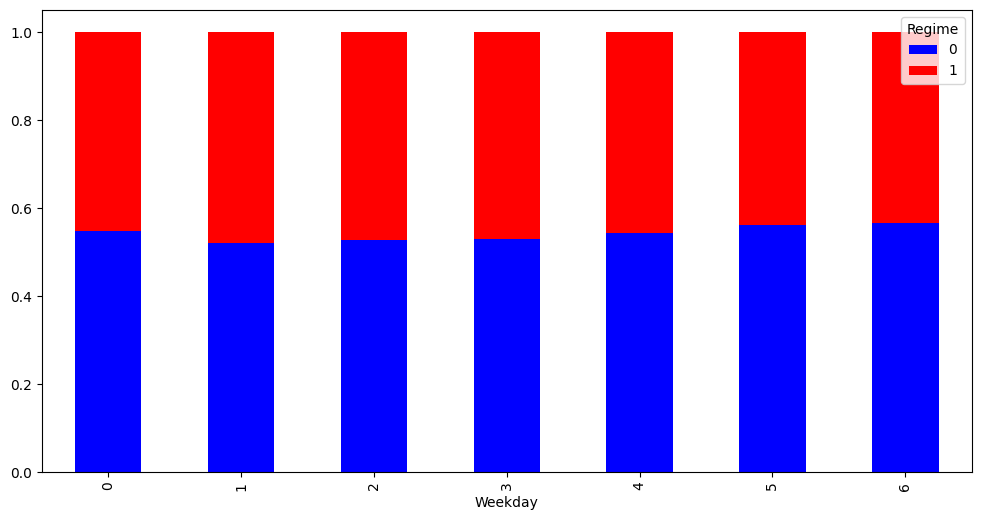

In [53]:
time_series_df['Weekday'] = time_series_df.index.day_of_week

time_series_df.groupby('Weekday')['Regime'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(12, 6), color=['b', 'r']);

In [54]:
time_series_df['Day of Year'] = time_series_df.index.day_of_year

In [55]:
generation = time_series_df[list(range(96))].values
y = time_series_df['Regime'].values
day = time_series_df['Day of Year'].values
np.save('../data/X.npy', generation)
np.save('../data/y.npy', y)
np.save('../data/day.npy', day)

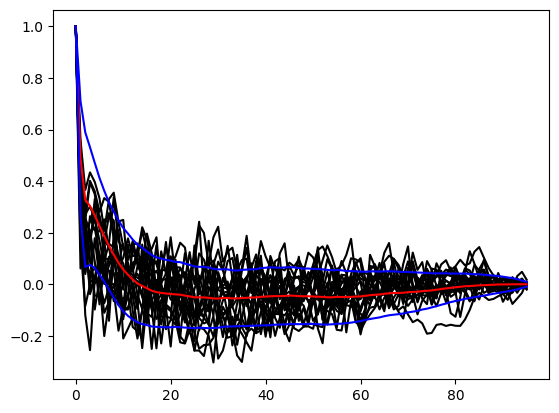

In [56]:
auto_corrs = complete_auto_corr(torch.FloatTensor(generation).reshape(-1, 1, 1, 96), 96)
for i in range(20):
    plt.plot(auto_corrs[:,i], label=f"lag={i}", color='black')

plt.plot(auto_corrs.mean(axis=1), label="mean", color='red')
plt.plot(auto_corrs.mean(axis=1) + auto_corrs.std(axis=1), label="mean + std", color='blue')
plt.plot(auto_corrs.mean(axis=1) - auto_corrs.std(axis=1), label="mean - std", color='blue')
plt.show()